In [14]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import layers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score
import glob
import warnings
warnings.filterwarnings('ignore')

# ======================== Load Data ========================

dataset_dir = 'trashnet/raw_data'  # Update as necessary

files = glob.glob(dataset_dir + "/*/*")
np.random.shuffle(files)
labels = [os.path.dirname(i).split("/")[-1] for i in files]
dataframe = pd.DataFrame(zip(files, labels), columns=["Image", "Label"])

print("Dataset Sample:")
print(dataframe.head())

# ======================== Dataset Preparation ========================

target_size = (224, 224)
batch_size = 64
validation_split = 0.2

train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="training",
    seed=50,
    image_size=target_size,
    batch_size=batch_size,
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="validation",
    seed=100,
    image_size=target_size,
    batch_size=batch_size,
)

class_names = train.class_names
print("Class Names:", class_names)

# ======================== Data Augmentation ========================

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Applying data augmentation in the pipeline
train = train.map(lambda x, y: (data_augmentation(x, training=True), y))
AUTOTUNE = tf.data.AUTOTUNE
train = train.cache().prefetch(buffer_size=AUTOTUNE)
validation = validation.cache().prefetch(buffer_size=AUTOTUNE)

# ======================== Build the ResNet50V2 Model ========================

base_model = tf.keras.applications.ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

eco_classify_ai = models.Sequential([
    layers.Rescaling(1./255),
    base_model,
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

eco_classify_ai.summary()
tf.keras.utils.plot_model(
    eco_classify_ai,
    to_file='resnet50v2_waste_classifier_model.png',
    show_shapes=True,
    show_layer_names=True,
    show_dtype=True,
    dpi=300)

# ======================== Compile and Train ========================

checkpoint = ModelCheckpoint(
    "best_resnet50v2_waste_classifier.keras",
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)
early_stopping = EarlyStopping(
    patience=8,
    restore_best_weights=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

eco_classify_ai.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Initial training (training top layers)
history = eco_classify_ai.fit(
    train,
    epochs=20,
    validation_data=validation,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

# ======================== Fine-tuning ========================

base_model.trainable = True

fine_tune_at = int(len(base_model.layers) * 0.75)

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

eco_classify_ai.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 10
total_epochs = 20 + fine_tune_epochs

history_fine = eco_classify_ai.fit(
    train,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1] + 1,
    validation_data=validation,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

# ======================== Plot Training Curves ========================

acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('resnet50v2_training_curves.png', dpi=300)
plt.show()

# ======================== Evaluate on Validation Data ========================

X_val, y_val = [], []

for images, labels in validation:
    X_val.extend(images.numpy())
    y_val.extend(labels.numpy())

X_val = np.array(X_val)
y_val = np.array(y_val)

predictions = eco_classify_ai.predict(X_val)
y_pred = [np.argmax(pred) for pred in predictions]

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('resnet50v2_confusion_matrix.png', dpi=300)
plt.show()

# Metrics Calculation
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=class_names))

# Save the trained model
eco_classify_ai.save('resnet50v2_waste_classifier_model.keras')
print("ResNet50V2 Waste Classification Model Saved Successfully.")


Dataset Sample:
                                         Image               Label
0         trashnet/raw_data\paper\paper367.jpg      raw_data\paper
1         trashnet/raw_data\glass\glass292.jpg      raw_data\glass
2          trashnet/raw_data\metal\metal58.jpg      raw_data\metal
3         trashnet/raw_data\metal\metal180.jpg      raw_data\metal
4  trashnet/raw_data\cardboard\cardboard70.jpg  raw_data\cardboard
Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
Class Names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ ?                           │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,564,800 (89.89 MB)

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

TensorFlow Version: 2.20.0
GPU Available: 0
🎯 OPTIMIZED ResNet50V2 WASTE CLASSIFICATION
TensorFlow: 2.20.0
Mixed Precision: True
Batch Size: 32
Image Size: (224, 224)
Training Epochs: 25
🚀 OPTIMIZED ResNet50V2 TRAINING PIPELINE
⚠️  No GPU detected - training will use CPU
Loading dataset from: trashnet/raw_data
Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Training batches: 64
Validation batches: 16
Model created with 24,756,998 trainable parameters

Model Architecture:


Model: "optimized_resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_image[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_preact_bn        │ (None, 56, 56, 64)        │             256 │ pool1_pool[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_preact_relu      │ (None, 56, 56, 64)        │               0 │ conv2_block1_preact_bn[0]… │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,096 │ conv2_block1_preact_relu[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_pad            │ (None, 58, 58, 64)        │               0 │ conv2_block1_1_relu[0][0]  │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,864 │ conv2_block1_2_pad[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │               

 Total params: 24,756,998 (94.44 MB)

 Trainable params: 1,187,078 (4.53 MB)

 Non-trainable params: 23,569,920 (89.91 MB)


PHASE 1: Training with frozen ResNet50V2 base
Epoch 1/12
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4860 - loss: 2.0603 - precision: 0.6376 - recall: 0.2738 - top2_accuracy: 0.6716  
Epoch 1: val_accuracy improved from None to 0.73267, saving model to resnet50v2_waste_classifier_best.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 397s 6s/step - accuracy: 0.5668 - loss: 1.8378 - precision: 0.7074 - recall: 0.3150 - top2_accuracy: 0.7522 - val_accuracy: 0.7327 - val_loss: 1.1415 - val_precision: 0.8618 - val_recall: 0.5802 - val_top2_accuracy: 0.8733 - learning_rate: 0.0010
Epoch 2/12
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7835 - loss: 1.3327 - precision: 0.8610 - recall: 0.4028 - top2_accuracy: 0.9074  
Epoch 2: val_accuracy improved from 0.73267 to 0.80990, saving model to resnet50v2_waste_classifier_best.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 361s 6s/step - accuracy: 0.7591 - loss: 1.3503 - precision: 0.8546 - recall: 0.3926 - top2_accuracy: 0.8986 - val_accuracy: 0.8099 - val_loss

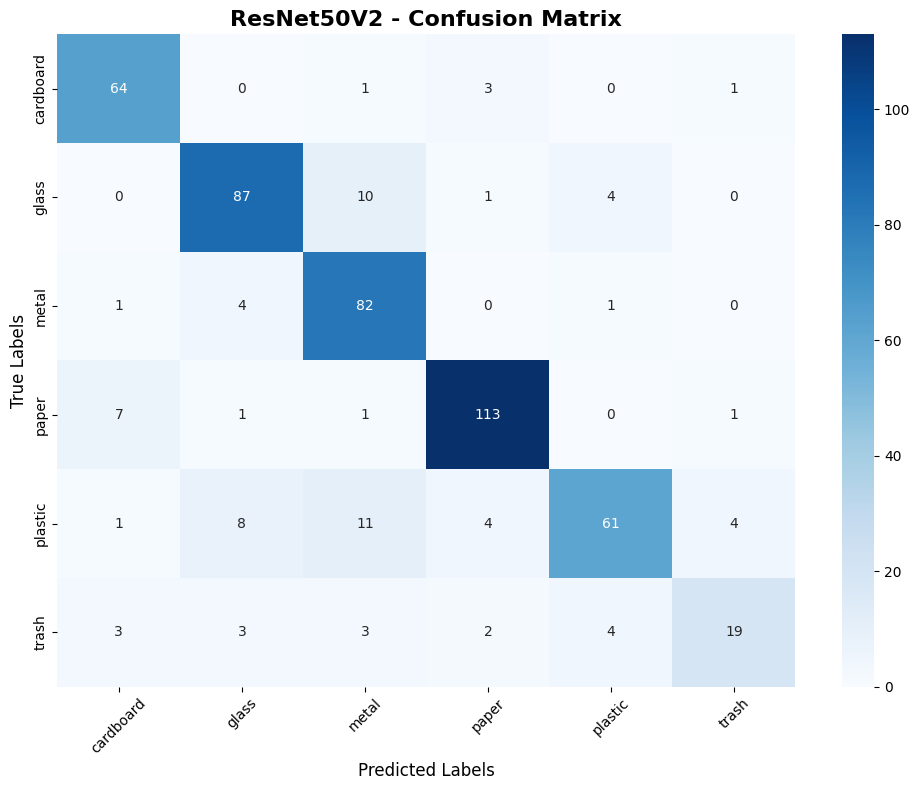

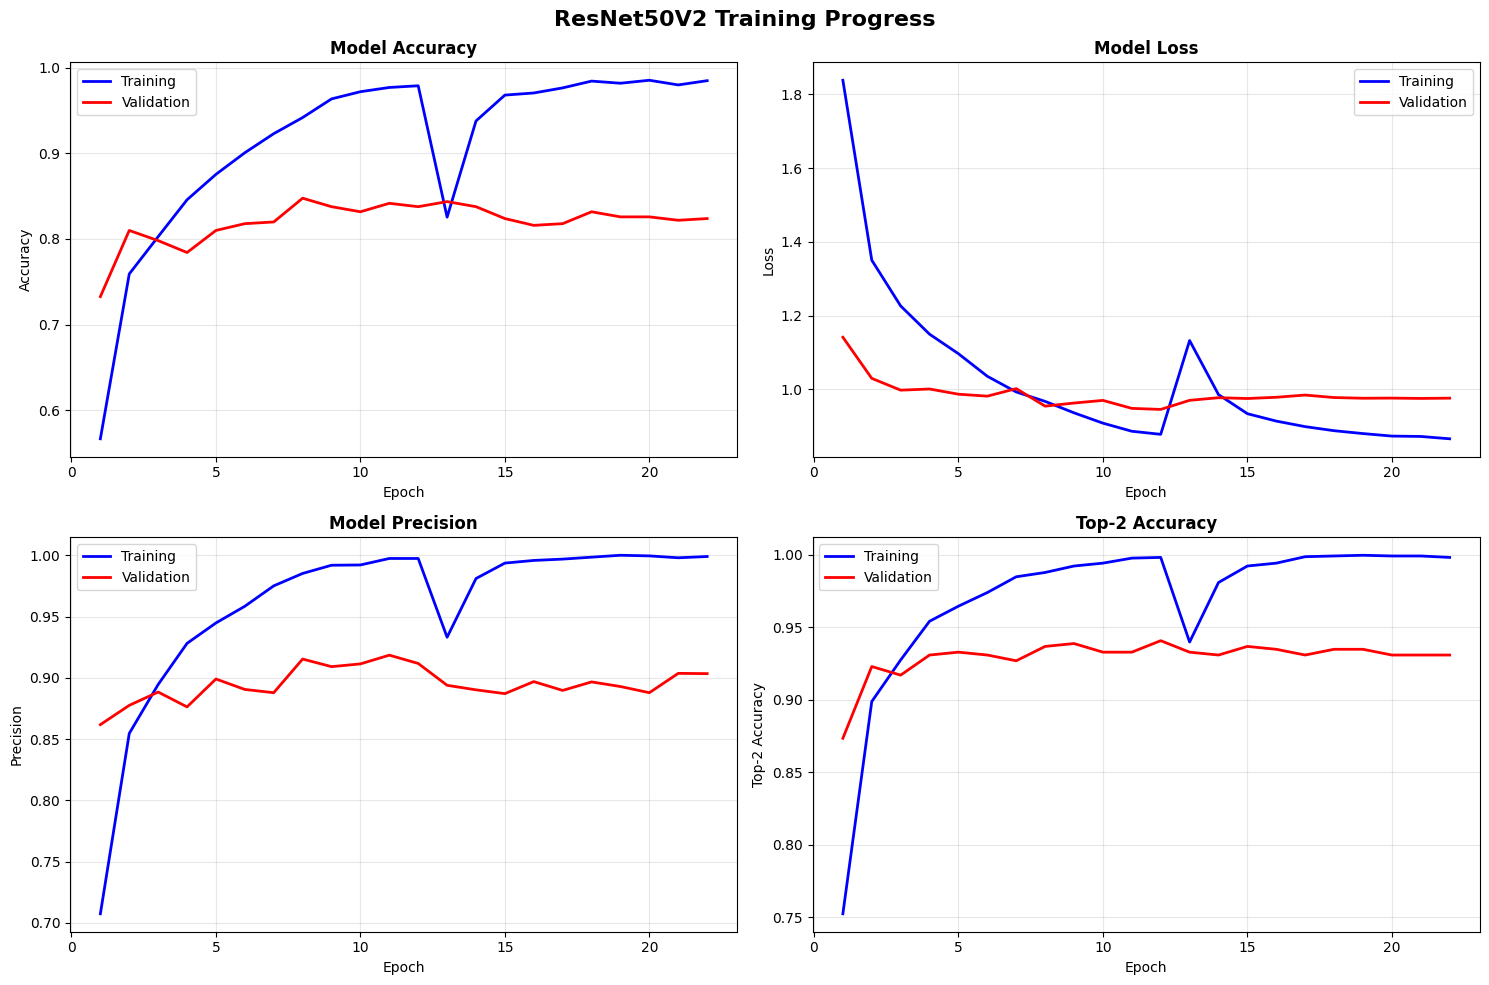


💾 Final model saved: resnet50v2_waste_classifier_final.keras

🎉 TRAINING COMPLETED SUCCESSFULLY!

📁 Generated Files:
• Model: resnet50v2_waste_classifier_final.keras
• Best Model: resnet50v2_waste_classifier_best.keras
• Training Curves: resnet50v2_training_curves.png
• Confusion Matrix: resnet50v2_confusion_matrix.png
• Logs: logs/ directory

🚀 Usage for Predictions:
predicted_class, confidence = load_and_predict(
    'resnet50v2_waste_classifier_best.keras',
    'your_image.jpg',
    ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
)


In [2]:
#importing libraries

import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
import time
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

print("TensorFlow Version:", tf.__version__)
print("GPU Available:", len(tf.config.list_physical_devices('GPU')))

#Configuring Class
class ResNet50V2Config:
    """Optimized configuration for ResNet50V2 waste classification"""

    # Dataset Configuration
    DATASET_DIR = 'trashnet/raw_data'
    IMAGE_SIZE = (224, 224)
    CHANNELS = 3
    BATCH_SIZE = 32  # Optimal for ResNet50V2
    VALIDATION_SPLIT = 0.2

    # Training Configuration
    EPOCHS = 25
    INITIAL_LR = 0.001
    FINE_TUNE_LR = 1e-5
    FINE_TUNE_AT = 120  # Unfreeze top layers (ResNet50V2 has ~175 layers)

    # Optimization Settings
    MIXED_PRECISION = True  # Enable for memory efficiency
    PREFETCH_BUFFER = tf.data.AUTOTUNE
    CACHE_DATA = True

    # Regularization
    DROPOUT_RATE = 0.5
    L2_REGULARIZATION = 1e-4
    LABEL_SMOOTHING = 0.1

    # Data Augmentation
    ROTATION_RANGE = 20
    BRIGHTNESS_DELTA = 0.1
    CONTRAST_RANGE = (0.8, 1.2)
    MIXUP_ALPHA = 0.2  # MixUp augmentation

    # Callbacks Configuration
    EARLY_STOPPING_PATIENCE = 10
    LR_REDUCE_PATIENCE = 6
    LR_REDUCE_FACTOR = 0.2

    # Output Settings
    MODEL_NAME = 'resnet50v2_waste_classifier'
    SAVE_FORMAT = 'keras'

config = ResNet50V2Config()

#optimization for gpu 

def setup_gpu():
    """Configure GPU for optimal performance"""
    gpus = tf.config.list_physical_devices('GPU')

    if gpus:
        try:
            # Enable memory growth
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print(f"✅ GPU memory growth enabled for {len(gpus)} GPU(s)")

            # Enable mixed precision if configured
            if config.MIXED_PRECISION:
                tf.keras.mixed_precision.set_global_policy('mixed_float16')
                print("✅ Mixed precision (FP16) enabled")

        except RuntimeError as e:
            print(f"GPU setup error: {e}")
    else:
        print("⚠️  No GPU detected - training will use CPU")

    return len(gpus) > 0

#The data pipline
class OptimizedDataPipeline:
    """High-performance data pipeline using tf.data"""

    def __init__(self):
        self.class_names = None
        self.num_classes = 0
        self.train_size = 0
        self.val_size = 0

    def create_datasets(self):
        """Create optimized training and validation datasets"""

        if not os.path.exists(config.DATASET_DIR):
            raise FileNotFoundError(f"Dataset not found at {config.DATASET_DIR}")

        print(f"Loading dataset from: {config.DATASET_DIR}")

        # Creating training dataset
        train_ds = tf.keras.utils.image_dataset_from_directory(
            config.DATASET_DIR,
            validation_split=config.VALIDATION_SPLIT,
            subset="training",
            seed=42,
            image_size=config.IMAGE_SIZE,
            batch_size=config.BATCH_SIZE,
            label_mode='categorical'
        )

        # Creating validation dataset
        val_ds = tf.keras.utils.image_dataset_from_directory(
            config.DATASET_DIR,
            validation_split=config.VALIDATION_SPLIT,
            subset="validation", 
            seed=42,
            image_size=config.IMAGE_SIZE,
            batch_size=config.BATCH_SIZE,
            label_mode='categorical'
        )

        self.class_names = train_ds.class_names
        self.num_classes = len(self.class_names)
        self.train_size = tf.data.experimental.cardinality(train_ds).numpy()
        self.val_size = tf.data.experimental.cardinality(val_ds).numpy()

        print(f"Classes: {self.class_names}")
        print(f"Training batches: {self.train_size}")
        print(f"Validation batches: {self.val_size}")

        # Apply optimizations
        train_ds = self._optimize_dataset(train_ds, is_training=True)
        val_ds = self._optimize_dataset(val_ds, is_training=False)

        return train_ds, val_ds

    def _optimize_dataset(self, dataset, is_training=True):
        """Apply performance optimizations to dataset"""

        # Normalize to [0,1]
        normalization_layer = tf.keras.layers.Rescaling(1./255)
        dataset = dataset.map(
            lambda x, y: (normalization_layer(x), y),
            num_parallel_calls=config.PREFETCH_BUFFER
        )

        if is_training:
            # Apply data augmentation
            dataset = dataset.map(
                self._augment_data,
                num_parallel_calls=config.PREFETCH_BUFFER
            )

            # Apply MixUp augmentation
            if config.MIXUP_ALPHA > 0:
                dataset = dataset.map(
                    lambda x, y: self._mixup(x, y),
                    num_parallel_calls=config.PREFETCH_BUFFER
                )

        # Performance optimizations
        if config.CACHE_DATA:
            dataset = dataset.cache()

        if is_training:
            dataset = dataset.shuffle(1000)

        dataset = dataset.prefetch(config.PREFETCH_BUFFER)

        return dataset

    @tf.function
    def _augment_data(self, image, label):
        """Advanced data augmentation"""

        # Random horizontal flip
        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_left_right(image)

        # Random rotation
        angle = tf.random.uniform(()) * config.ROTATION_RANGE * 2 * np.pi / 360
        image = tf.image.rot90(image, k=tf.cast(angle / (np.pi/2), tf.int32))

        # Random brightness
        image = tf.image.random_brightness(image, config.BRIGHTNESS_DELTA)

        # Random contrast
        image = tf.image.random_contrast(
            image, 
            config.CONTRAST_RANGE[0], 
            config.CONTRAST_RANGE[1]
        )

        # Random saturation
        image = tf.image.random_saturation(image, 0.8, 1.2)

        # Ensure values stay in [0,1]
        image = tf.clip_by_value(image, 0.0, 1.0)

        return image, label

    @tf.function
    def _mixup(self, x, y):
        """MixUp data augmentation"""
        batch_size = tf.shape(x)[0]

        # Sample mixing weight
        alpha = config.MIXUP_ALPHA
        lam = tf.random.uniform([batch_size, 1, 1, 1], 0, alpha)
        lam = tf.maximum(lam, 1 - lam)

        # Shuffle batch
        indices = tf.random.shuffle(tf.range(batch_size))
        x2 = tf.gather(x, indices)
        y2 = tf.gather(y, indices)

        # Mix images and labels
        mixed_x = lam * x + (1 - lam) * x2
        lam_y = lam[:, 0, 0, 0:1]
        mixed_y = lam_y * y + (1 - lam_y) * y2

        return mixed_x, mixed_y

#Optimized Resnet50V2
class OptimizedResNet50V2:
    """ResNet50V2 with advanced optimizations for waste classification"""

    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.model = None
        self.base_model = None

    def create_model(self):
        """Create optimized ResNet50V2 model"""

        # Define input layer
        inputs = tf.keras.layers.Input(
            shape=(*config.IMAGE_SIZE, config.CHANNELS),
            name='input_image'
        )

        # Create ResNet50V2 base model
        self.base_model = tf.keras.applications.ResNet50V2(
            weights='imagenet',
            include_top=False,
            input_tensor=inputs
        )

        # Initially freeze base model
        self.base_model.trainable = False

        # Add custom classification head
        x = self.base_model.output

        # Global Average Pooling
        x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool')(x)

        # Batch normalization for stability
        x = tf.keras.layers.BatchNormalization(name='bn_features')(x)

        # First dense layer with dropout
        x = tf.keras.layers.Dense(
            512,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.L2(config.L2_REGULARIZATION),
            name='dense_512'
        )(x)

        x = tf.keras.layers.BatchNormalization(name='bn_dense')(x)
        x = tf.keras.layers.Dropout(config.DROPOUT_RATE, name='dropout_1')(x)

        # Second dense layer
        x = tf.keras.layers.Dense(
            256,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.L2(config.L2_REGULARIZATION),
            name='dense_256'
        )(x)

        x = tf.keras.layers.Dropout(0.3, name='dropout_2')(x)

        # Output layer
        predictions = tf.keras.layers.Dense(
            self.num_classes,
            activation='softmax',
            dtype='float32',  # Ensure float32 for mixed precision
            name='predictions'
        )(x)

        # Create final model
        self.model = tf.keras.Model(
            inputs=inputs,
            outputs=predictions,
            name='optimized_resnet50v2'
        )

        print(f"Model created with {self.model.count_params():,} trainable parameters")
        return self.model

    def compile_model(self, learning_rate=None):
        """Compile model with optimized settings"""

        if learning_rate is None:
            learning_rate = config.INITIAL_LR

        # Use AdamW optimizer with weight decay
        optimizer = tf.keras.optimizers.AdamW(
            learning_rate=learning_rate,
            weight_decay=config.L2_REGULARIZATION,
            clipnorm=1.0  # Gradient clipping
        )

        # Loss function with label smoothing
        loss = tf.keras.losses.CategoricalCrossentropy(
            label_smoothing=config.LABEL_SMOOTHING
        )

        # Comprehensive metrics
        metrics = [
            'accuracy',
            tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top2_accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]

        self.model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=metrics
        )

        return self.model

    def enable_fine_tuning(self):
        """Enable fine-tuning of top layers"""

        self.base_model.trainable = True

        # Freeze early layers
        for layer in self.base_model.layers[:config.FINE_TUNE_AT]:
            layer.trainable = False

        trainable_layers = sum(1 for layer in self.base_model.layers if layer.trainable)
        print(f"Fine-tuning enabled: {trainable_layers} layers unfrozen")

        # Recompile with lower learning rate
        self.compile_model(learning_rate=config.FINE_TUNE_LR)

#Trainig the callback

def create_callbacks(model_name):
    """Create comprehensive callback suite"""

    callbacks = []

    # Model checkpoint
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=f'{model_name}_best.keras',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=1
    )
    callbacks.append(checkpoint)

    # Early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=config.EARLY_STOPPING_PATIENCE,
        restore_best_weights=True,
        mode='max',
        verbose=1
    )
    callbacks.append(early_stopping)

    # Learning rate reduction
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=config.LR_REDUCE_FACTOR,
        patience=config.LR_REDUCE_PATIENCE,
        min_lr=1e-7,
        verbose=1
    )
    callbacks.append(reduce_lr)

    # TensorBoard logging
    tensorboard = tf.keras.callbacks.TensorBoard(
        log_dir=f'logs/{model_name}_{datetime.now().strftime("%Y%m%d_%H%M%S")}',
        histogram_freq=1
    )
    callbacks.append(tensorboard)

    return callbacks

#training Pipline
class ResNet50V2TrainingPipeline:
    """Complete training pipeline for ResNet50V2"""

    def __init__(self):
        self.model = None
        self.history = None
        self.data_pipeline = None

    def run_training(self):
        """Execute complete training pipeline"""

        print("🚀 OPTIMIZED ResNet50V2 TRAINING PIPELINE")
        print("=" * 55)

        # Setup GPU
        has_gpu = setup_gpu()

        # Create data pipeline
        self.data_pipeline = OptimizedDataPipeline()
        train_ds, val_ds = self.data_pipeline.create_datasets()

        # Create and compile model
        model_builder = OptimizedResNet50V2(self.data_pipeline.num_classes)
        self.model = model_builder.create_model()
        model_builder.compile_model()

        # Print model summary
        print("\nModel Architecture:")
        self.model.summary()

        # Create callbacks
        callbacks = create_callbacks(config.MODEL_NAME)

        # Phase 1: Initial training with frozen base model
        print("\n" + "=" * 55)
        print("PHASE 1: Training with frozen ResNet50V2 base")
        print("=" * 55)

        start_time = time.time()

        initial_epochs = config.EPOCHS // 2
        initial_history = self.model.fit(
            train_ds,
            epochs=initial_epochs,
            validation_data=val_ds,
            callbacks=callbacks,
            verbose=1
        )

        # Phase 2: Fine-tuning with unfrozen layers
        print("\n" + "=" * 55)
        print("PHASE 2: Fine-tuning with unfrozen layers")
        print("=" * 55)

        model_builder.enable_fine_tuning()

        fine_tune_history = self.model.fit(
            train_ds,
            epochs=config.EPOCHS,
            initial_epoch=initial_epochs,
            validation_data=val_ds,
            callbacks=callbacks,
            verbose=1
        )

        training_time = time.time() - start_time

        # Combine histories
        self.history = self._combine_histories(initial_history, fine_tune_history)

        print(f"\n✅ Training completed in {training_time:.2f} seconds ({training_time/60:.1f} minutes)")

        # Evaluate model
        self._evaluate_model(val_ds)

        # Save final model
        final_model_path = f'{config.MODEL_NAME}_final.{config.SAVE_FORMAT}'
        self.model.save(final_model_path)
        print(f"\n💾 Final model saved: {final_model_path}")

        return self.model, self.history

    def _combine_histories(self, hist1, hist2):
        """Combine training histories"""
        combined = {}
        for key in hist1.history.keys():
            combined[key] = hist1.history[key] + hist2.history[key]

        # Create a simple object to hold the combined history
        class CombinedHistory:
            def __init__(self, history_dict):
                self.history = history_dict

        return CombinedHistory(combined)

    def _evaluate_model(self, val_ds):
        """Comprehensive model evaluation"""

        print("\n" + "=" * 55)
        print("MODEL EVALUATION")
        print("=" * 55)

        # Get predictions
        print("Generating predictions...")

        # Collect all validation data
        y_true = []
        y_pred_probs = []

        for images, labels in val_ds:
            predictions = self.model.predict(images, verbose=0)
            y_pred_probs.extend(predictions)
            y_true.extend(tf.argmax(labels, axis=1).numpy())

        y_true = np.array(y_true)
        y_pred_probs = np.array(y_pred_probs)
        y_pred = np.argmax(y_pred_probs, axis=1)

        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        # Print results
        print(f"\n📊 FINAL RESULTS:")
        print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
        print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
        print(f"F1-Score:  {f1:.4f} ({f1*100:.2f}%)")

        # Classification report
        print("\n📋 Detailed Classification Report:")
        print(classification_report(
            y_true, y_pred,
            target_names=self.data_pipeline.class_names,
            digits=4
        ))

        # Generate visualizations
        self._plot_confusion_matrix(y_true, y_pred)
        self._plot_training_curves()

        return {
            'accuracy': accuracy,
            'precision': precision, 
            'recall': recall,
            'f1_score': f1
        }

    def _plot_confusion_matrix(self, y_true, y_pred):
        """Plot confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(10, 8))
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=self.data_pipeline.class_names,
            yticklabels=self.data_pipeline.class_names
        )
        plt.title('ResNet50V2 - Confusion Matrix', fontsize=16, fontweight='bold')
        plt.xlabel('Predicted Labels', fontsize=12)
        plt.ylabel('True Labels', fontsize=12)
        plt.xticks(rotation=45)
        plt.tight_layout()

        plt.savefig('resnet50v2_confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()

    def _plot_training_curves(self):
        """Plot training curves"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

        epochs = range(1, len(self.history.history['accuracy']) + 1)

        # Accuracy
        ax1.plot(epochs, self.history.history['accuracy'], 'b-', label='Training', linewidth=2)
        ax1.plot(epochs, self.history.history['val_accuracy'], 'r-', label='Validation', linewidth=2)
        ax1.set_title('Model Accuracy', fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Loss
        ax2.plot(epochs, self.history.history['loss'], 'b-', label='Training', linewidth=2)
        ax2.plot(epochs, self.history.history['val_loss'], 'r-', label='Validation', linewidth=2)
        ax2.set_title('Model Loss', fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Precision
        if 'precision' in self.history.history:
            ax3.plot(epochs, self.history.history['precision'], 'b-', label='Training', linewidth=2)
            ax3.plot(epochs, self.history.history['val_precision'], 'r-', label='Validation', linewidth=2)
            ax3.set_title('Model Precision', fontweight='bold')
            ax3.set_xlabel('Epoch')
            ax3.set_ylabel('Precision')
            ax3.legend()
            ax3.grid(True, alpha=0.3)

        # Top-2 Accuracy
        if 'top2_accuracy' in self.history.history:
            ax4.plot(epochs, self.history.history['top2_accuracy'], 'b-', label='Training', linewidth=2)
            ax4.plot(epochs, self.history.history['val_top2_accuracy'], 'r-', label='Validation', linewidth=2)
            ax4.set_title('Top-2 Accuracy', fontweight='bold')
            ax4.set_xlabel('Epoch')
            ax4.set_ylabel('Top-2 Accuracy')
            ax4.legend()
            ax4.grid(True, alpha=0.3)

        plt.suptitle('ResNet50V2 Training Progress', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig('resnet50v2_training_curves.png', dpi=300, bbox_inches='tight')
        plt.show()

#Prediction

def load_and_predict(model_path, image_path, class_names):
    """Load trained model and predict single image"""

    # Load model
    model = tf.keras.models.load_model(model_path)

    # Load and preprocess image
    img = tf.keras.utils.load_img(image_path, target_size=config.IMAGE_SIZE)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) / 255.0

    # Make prediction
    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_idx]
    confidence = predictions[0][predicted_class_idx]

    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence:.4f} ({confidence*100:.2f}%)")

    # Show top 3 predictions
    top_3_idx = np.argsort(predictions[0])[-3:][::-1]
    print("\nTop 3 Predictions:")
    for i, idx in enumerate(top_3_idx, 1):
        print(f"{i}. {class_names[idx]}: {predictions[0][idx]:.4f} ({predictions[0][idx]*100:.2f}%)")

    return predicted_class, confidence



def main():
    """Main execution function"""

    print("🎯 OPTIMIZED ResNet50V2 WASTE CLASSIFICATION")
    print("=" * 60)
    print(f"TensorFlow: {tf.__version__}")
    print(f"Mixed Precision: {config.MIXED_PRECISION}")
    print(f"Batch Size: {config.BATCH_SIZE}")
    print(f"Image Size: {config.IMAGE_SIZE}")
    print(f"Training Epochs: {config.EPOCHS}")
    print("=" * 60)

    # Run training pipeline
    pipeline = ResNet50V2TrainingPipeline()
    model, history = pipeline.run_training()

    print("\n🎉 TRAINING COMPLETED SUCCESSFULLY!")
    print("\n📁 Generated Files:")
    print("• Model: resnet50v2_waste_classifier_final.keras")
    print("• Best Model: resnet50v2_waste_classifier_best.keras")
    print("• Training Curves: resnet50v2_training_curves.png")
    print("• Confusion Matrix: resnet50v2_confusion_matrix.png")
    print("• Logs: logs/ directory")

    print("\n🚀 Usage for Predictions:")
    print("predicted_class, confidence = load_and_predict(")
    print("    'resnet50v2_waste_classifier_best.keras',")
    print("    'your_image.jpg',")
    print("    ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']")
    print(")")

    return model, history

if __name__ == "__main__":
    model, history = main()



In [5]:
predicted_class, confidence = load_and_predict(
    'resnet50v2_waste_classifier_best.keras',
    'WhatsApp Image 2025-08-31 at 18.31.39_5f2056fa.jpg',
    ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
)

Predicted Class: plastic
Confidence: 0.4317 (43.17%)

Top 3 Predictions:
1. plastic: 0.4317 (43.17%)
2. cardboard: 0.1956 (19.56%)
3. paper: 0.1566 (15.66%)


In [1]:
import tensorflow as tf

# Load your existing model
model = tf.keras.models.load_model('resnet50v2_waste_classifier_final.keras')

# Create TFLite converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Optional: Enable optimizations to reduce size further
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_model = converter.convert()

# Save the TFLite model file
with open('waste_classifier.tflite', 'wb') as f:
    f.write(tflite_model)

print("TensorFlow Lite model saved as waste_classifier.tflite")


INFO:tensorflow:Assets written to: C:\Users\Abhishek\AppData\Local\Temp\tmpenaha1pk\assets


INFO:tensorflow:Assets written to: C:\Users\Abhishek\AppData\Local\Temp\tmpenaha1pk\assets


Saved artifact at 'C:\Users\Abhishek\AppData\Local\Temp\tmpenaha1pk'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_image')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2108338266784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2108338271712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2108338528928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2108338530864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2108338524352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2108338526640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2108338534208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2108338534560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2108338535440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2108338535792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  210